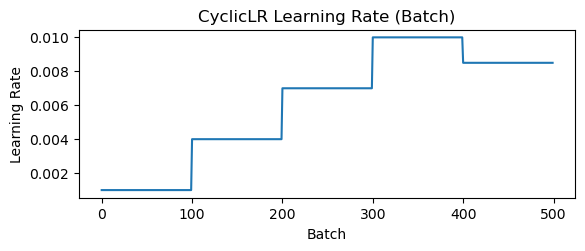

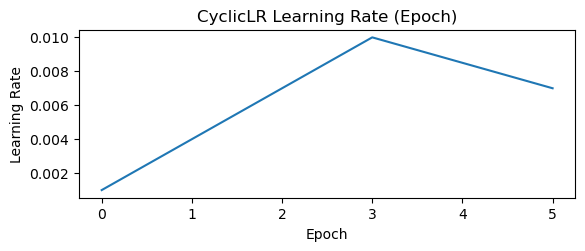

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# 定义模型
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        return self.fc(x)


# 创建模型和优化器
model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 设置CyclicLR调度器
step_size = 3
base_lr = 0.001
max_lr = 0.01
cyclic_lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=base_lr,
    max_lr=max_lr,
    step_size_up=step_size,
    step_size_down=step_size * 2,
)


# 定义一个用于模拟训练的函数
def train_model(num_epochs, num_batches_per_epoch):
    learning_rates_batch = []
    learning_rates_epoch = []
    for epoch in range(num_epochs):
        # 记录学习率
        learning_rates_epoch.append(optimizer.param_groups[0]["lr"])
        for batch in range(num_batches_per_epoch):
            learning_rates_batch.append(optimizer.param_groups[0]["lr"])

            # 更新CyclicLR调度器，在每个epoch结束时进行一次更新
        cyclic_lr_scheduler.step()

    learning_rates_epoch.append(optimizer.param_groups[0]["lr"])
    return learning_rates_batch, learning_rates_epoch


# 模拟训练过程，设置训练的epoch和每个epoch的batch数
num_epochs = 5
num_batches_per_epoch = 100

learning_rates_batch, learning_rates_epoch = train_model(
    num_epochs, num_batches_per_epoch
)

# 绘制学习率随着batch的变化曲线
plt.subplot(2, 1, 1)
plt.plot(range(len(learning_rates_batch)), learning_rates_batch)
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("CyclicLR Learning Rate (Batch)")
plt.show()

# 绘制学习率随着epoch的变化曲线
plt.subplot(2, 1, 2)
plt.plot(range(len(learning_rates_epoch)), learning_rates_epoch)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("CyclicLR Learning Rate (Epoch)")
plt.show()

In [19]:
import torch
import numpy as np
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1,1).cuda()
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1).cuda()

def generate_new_state_dict(state_dict):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace('model.', '')] = v
    return new_state_dict
    

def pgd_attack(model, images, labels, eps=0.2, alpha=0.008, iters=40, device='cuda:0'):
    images = images.to(device)
    labels = labels.to(device)
    loss = torch.nn.BCEWithLogitsLoss()

    ori_images = images.data

    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images + alpha*images.grad.sign()
        eta = torch.clamp(attack_images - ori_images, min=-eps, max=eps)
        images = (ori_images + eta).detach_()
    images = images * imagenet_std + imagenet_mean
    images = torch.clamp(images, 0, 1)
    return images

import timm
from dataset import *
model = timm.create_model("resnet34", pretrained=False, num_classes=1).cuda()
model.load_state_dict(generate_new_state_dict(torch.load('./best.ckpt')['state_dict']))
model.eval()
train_data_loader = get_dataloader(transform=test_transform, bs=1)


In [20]:
for i, (img, label) in enumerate(train_data_loader):
    img, label = img.cuda(), label.cuda()
    result = pgd_attack(model, img, label)
    label = label.cpu().numpy()[0][0]
    cv2.imwrite(f'./phase2/{i:05d}_{int(label)}.jpg', result[0].permute(1, 2, 0).cpu().numpy() * 255)

KeyboardInterrupt: 

In [10]:
img = cv2.imread('./phase2/00058_1.jpg')
img = test_transform(image=img)['image']
torch.sigmoid(model(img.unsqueeze(0).cuda()))

(tensor([[0.0291]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.0187]], device='cuda:0', grad_fn=<SigmoidBackward0>))

In [6]:
result.shape

torch.Size([1, 3, 224, 224])